In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_path = 'deep-learning-v2-pytorch/project-bikesharing/Bike-Sharing-Dataset/hour.csv'
rides = pd.read_csv(data_path)

In [3]:
rides.head()

instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

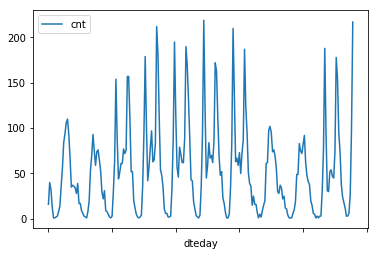

In [4]:
rides[:24*10].plot(x='dteday', y='cnt')

In [5]:
rides2 = rides[:]
dummy_fields = ['season', 'mnth', 'weathersit', 'hr', 'weekday']

for field in dummy_fields:
    rides2 = pd.get_dummies(rides2, columns=[field])

In [6]:
fields_to_drop = ['instant', 'dteday', 
                   'atemp', 'workingday']
rides2 = rides2.drop(fields_to_drop, axis=1)

In [7]:
quant_features = [
    'casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed'
]
scaled_features = {}
for field in quant_features:
    mean, std = rides2[field].mean(), rides2[field].std()
    scaled_features[field] = [mean, std]
    rides2.loc[:, field] = (rides2[field] - mean) / std

In [8]:
rides2.head()

yr  holiday      temp       hum  windspeed    casual  registered       cnt  \
0   0        0 -1.334609  0.947345  -1.553844 -0.662736   -0.930162 -0.956312   
1   0        0 -1.438475  0.895513  -1.553844 -0.561326   -0.804632 -0.823998   
2   0        0 -1.438475  0.895513  -1.553844 -0.622172   -0.837666 -0.868103   
3   0        0 -1.334609  0.636351  -1.553844 -0.662736   -0.949983 -0.972851   
4   0        0 -1.334609  0.636351  -1.553844 -0.723582   -1.009445 -1.039008   

   season_1  season_2    ...      hr_21  hr_22  hr_23  weekday_0  weekday_1  \
0         1         0    ...          0      0      0          0          0   
1         1         0    ...          0      0      0          0          0   
2         1         0    ...          0      0      0          0          0   
3         1         0    ...          0      0      0          0          0   
4         1         0    ...          0      0      0          0          0   

   weekday_2  weekday_3  weekday_4  weekday_5  weekday_6  
0          0          0          0          0          1  
1          0          0          0          0          1  
2          0          0          0          0          1  
3          0          0          0          0          1  
4          0          0          0          0          1  

[5 rows x 59 columns]

In [9]:
data = rides2[:]

In [10]:
test_data = data[-21*24:]
data = data[:-21*24]

In [11]:
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

In [12]:
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

In [13]:
print('test %s %s' % (test_features.shape, test_targets.shape))
print('train %s %s' % (train_features.shape, train_targets.shape))
print('val %s %s' % (val_features.shape, val_targets.shape))

test (504, 56) (504, 3)
train (15435, 56) (15435, 3)
val (1440, 56) (1440, 3)


In [18]:
import sys
import math

def MSE(y, Y):
    return np.mean((y-Y)**2)

class NeuralNetwork(object):
    def __init__(self, n_input, n_hidden, n_output, lr):
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_output = n_output        
        self.w1 = np.random.normal(0.0, n_input**-0.5, (n_input, n_hidden))
        self.w2 = np.random.normal(0.0, n_hidden**-0.5, (n_hidden, n_output))        
        self.lr = lr                
        self.activate = lambda x: 1 / (1 + np.exp(-x))
        
    def train(self, features, targets):
        dw1_batch = np.zeros(self.w1.shape)
        dw2_batch = np.zeros(self.w2.shape)
        n_records = features.shape[0]
        for x, y in zip(features, targets):
            x = np.array(x).reshape((1, self.n_input))
            y = np.array(y).reshape((1, self.n_output))
            
            # forward pass
            h_out = self.activate(x.dot(self.w1))            
            out = h_out.dot(self.w2)
            
            """
            print('h_out %s' % (h_out.shape,))
            print('out %s' % (out.shape,))            
            print('y %s' % (y.shape,))
            """
            

            # back propagation
            error_term_w2 = out - y
            #print('error_term_w2 %s' % (error_term_w2.shape, ))
            
            dw2 = h_out.T * error_term_w2            
            #print('dw2 %s' % (dw2.shape,))
        
            error_term_w1 = error_term_w2.dot(self.w2.T) * (h_out * (1-h_out))
            dw1 = x.T * error_term_w1
            
            """
            print('error_term_w2.dot(self.w2.T) %s' % (error_term_w2.dot(self.w2.T).shape,))
            print('(h_out * (1-h_out)) %s' % ((h_out * (1-h_out)).shape,))
            print('error_term_w1 %s' % (error_term_w1.shape,))
            """
            
            dw2_batch += dw2
            dw1_batch += dw1
            
        
        self.w1 -= dw1_batch/n_records * self.lr
        self.w2 -= dw2_batch/n_records * self.lr
        
            
    def run(self, features):
        h_out = self.activate(features.dot(self.w1))
        return h_out.dot(self.w2)
        

        
        
import unittest
inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'deep-learning-v2-pytorch/project-bikesharing/bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activate(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.w1 = test_w_i_h.copy()
        network.w2 = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.w2, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.w1,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.w1 = test_w_i_h.copy()
        network.w2 = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)        

.....
----------------------------------------------------------------------
Ran 5 tests in 0.005s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

In [33]:
network = NeuralNetwork(train_features.shape[1], 50, 1, 0.02)            
iterations = 1000
losses = {'train':[], 'validation':[]}

for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.ix[batch].values, train_targets.ix[batch]['cnt']
                             
    network.train(X, y)
    
    # Printing out the training progress
    
    result = network.run(train_features).values.reshape((train_features.shape[0],))

    val_result = network.run(val_features).values.reshape((val_features.shape[0],))
    
    
    train_loss = MSE(result , train_targets['cnt'].values)
    val_loss = MSE(val_result, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)


Progress: 99.9% ... Training loss: 0.547 ... Validation loss: 0.917